# Analyse_IceMHWsrelations_Tiles_v1.py
Sea ice could have an impact on marine heatwaves. A first step towards analysing it is to look at the co-occurrence of sea ice melt or freeze and MHW onset or decay.
Ice concentration and freezing-melting flux are the main variables of interest here.
We first categorize MHWs and Heat Budget into different ice state (melting, freezing, or no ice) and then plot the results.

BR, 30/01/2023

v1: Revamped for publication, 31/07/2023

In [1]:
import xarray as xr
import proplot as pplt
import numpy as np
import pandas as pd
import marineHeatWaves as mhw
from pathlib import Path
import dask
pplt.rc['figure.facecolor'] = 'white'

In [2]:
from dask_jobqueue import SGECluster
from dask.distributed import Client

cluster = SGECluster(
    queue="compute",
    cores=30,          # Total number of cores per job
    processes=5,       # Cores/processes = threads/worker
    walltime="12:00:00",
    memory="250GB",    # Total amount of memory per job
    local_directory="~/Projects/SiberianHW/src/dask-worker-space/",
    scheduler_options={
        "dashboard_address": ":7880",
    },
)

cluster.scale(jobs=5)       # Number of workers
client = Client(cluster)    # Connect to that cluster
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SGECluster
Dashboard: /proxy/7880/status,
Dashboard: /proxy/7880/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://129.173.118.14:46025,Workers: 0
Dashboard: /proxy/7880/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Preprocessing
Define paths and load the tiled heat budgets and MLT.

In [4]:
# Path to data and figures
PathHome = str(Path.home())
Path2proc = Path(PathHome+"/Projects/SiberianHW/data/processed/")
Path2tiles = Path2proc.joinpath("tiles/")
Path2figs = Path(PathHome+"/Projects/SiberianHW/figures/")
# Load MLT for tiles
ds_MLT = xr.open_dataset(Path2proc.joinpath('MLT_tiles_3Oceans.nc'))
# Load Marine Heatwave detection
ds_mhws_filt = xr.open_dataset(Path2proc.joinpath('MHWfiltMean0.1_DetectionProperties_TiledMLT.nc'))
# Load HBterms integration
ds_mhw_attr = xr.open_dataset(Path2proc.joinpath('IntegratedHBTerms_forMHWAttribution.nc'))
# Load Ice Properties for tiles
ds_Ice = xr.open_dataset(Path2proc.joinpath('IceProp_tiles_3Oceans.nc')).drop('month')
ds_Ice['fmmflx'] = ds_Ice.fmmflx  * 86400
ds_Ice.fmmflx.attrs['Units'] = "kg m$^{-2}$ d$^{-1}$"

## Process data
Several steps are necessary before being able to plot and analyse the results:
* First need to rank the drivers, as done in other scripts (this is a bit repetitive, but fast enough)
* Then need to categorize MHWs depending on the ice state, including the onset and decay phases
* Then go one step further by focusing on the primary driver, including the residuals to calculate uncertainties.
This while processsing part is a bit messy because repeating some of the steps, but it works. 

### Rank drivers 
As in the `Analyse_MHWDrivers_Tiles_v1.py` script, rank the processes for each MHW and use the residual to calculate constraint on the results.

In [7]:
# Start by creating a ds with residual added to each of the 4 interesting terms
ds_mhw_attr_wres = ds_mhw_attr.copy() # Copy initial ds 
# Loop over variables
for var in ['Tendency_top','TotAdv_top','Qsr_net_top','Vert_Flux']:
    # Add residual to each term. Need to account for the fact that residual should be substracted from Tendency
    if var=='Tendency_top':
        ds_mhw_attr_wres[var+'_wres'] = ds_mhw_attr_wres[var]-ds_mhw_attr_wres['Resi_top']
    else:
        ds_mhw_attr_wres[var+'_wres'] = ds_mhw_attr_wres[var]+ds_mhw_attr_wres['Resi_top']

# Create specific dataframe containing one term with residual and the 3 others without, divide by Tendency
# Tendency with Residual
ds_dTdtWRes = ds_mhw_attr_wres[['TotAdv_top','Qsr_net_top','Vert_Flux']]/ds_mhw_attr_wres['Tendency_top_wres']
df_dTdtWRes_Onset = ds_dTdtWRes.sel(trend='Onset',drop=True).to_dataframe(dim_order=('tiles','mhw')).dropna()
df_dTdtWRes_Onset_ranks = df_dTdtWRes_Onset.rank(axis=1,ascending=False)
df_dTdtWRes_Decay = ds_dTdtWRes.sel(trend='Decay',drop=True).to_dataframe(dim_order=('tiles','mhw')).dropna()
df_dTdtWRes_Decay_ranks = df_dTdtWRes_Decay.rank(axis=1,ascending=False)
# Advection with Residual
ds_AdvWRes = ds_mhw_attr_wres[['TotAdv_top_wres','Qsr_net_top','Vert_Flux']]/ds_mhw_attr_wres['Tendency_top']
df_AdvWRes_Onset = ds_AdvWRes.sel(trend='Onset',drop=True).to_dataframe(dim_order=('tiles','mhw')).dropna()
df_AdvWRes_Onset_ranks = df_AdvWRes_Onset.rank(axis=1,ascending=False)
df_AdvWRes_Decay = ds_AdvWRes.sel(trend='Decay',drop=True).to_dataframe(dim_order=('tiles','mhw')).dropna()
df_AdvWRes_Decay_ranks = df_AdvWRes_Decay.rank(axis=1,ascending=False)
# Surface with Residual
ds_SurWRes = ds_mhw_attr_wres[['TotAdv_top','Qsr_net_top_wres','Vert_Flux']]/ds_mhw_attr_wres['Tendency_top']
df_SurWRes_Onset = ds_SurWRes.sel(trend='Onset',drop=True).to_dataframe(dim_order=('tiles','mhw')).dropna()
df_SurWRes_Onset_ranks = df_SurWRes_Onset.rank(axis=1,ascending=False)
df_SurWRes_Decay = ds_SurWRes.sel(trend='Decay',drop=True).to_dataframe(dim_order=('tiles','mhw')).dropna()
df_SurWRes_Decay_ranks = df_SurWRes_Decay.rank(axis=1,ascending=False)
# Bottom with Residual
ds_BotWRes = ds_mhw_attr_wres[['TotAdv_top','Qsr_net_top','Vert_Flux_wres']]/ds_mhw_attr_wres['Tendency_top']
df_BotWRes_Onset = ds_BotWRes.sel(trend='Onset',drop=True).to_dataframe(dim_order=('tiles','mhw')).dropna()
df_BotWRes_Onset_ranks = df_BotWRes_Onset.rank(axis=1,ascending=False)
df_BotWRes_Decay = ds_BotWRes.sel(trend='Decay',drop=True).to_dataframe(dim_order=('tiles','mhw')).dropna()
df_BotWRes_Decay_ranks = df_BotWRes_Decay.rank(axis=1,ascending=False)
# No Residual correction (the residuals are kept as a separate variable)
ds_NoResCorr = ds_mhw_attr_wres[['TotAdv_top','Qsr_net_top','Vert_Flux','Resi_top']]/ds_mhw_attr_wres['Tendency_top']
ds_NoResCorr_Onset = ds_NoResCorr.sel(trend='Onset',drop=True).to_dataframe(dim_order=('tiles','mhw')).dropna()
ds_NoResCorr_Onset_ranks = ds_NoResCorr_Onset.rank(axis=1,ascending=False)
ds_NoResCorr_Decay = ds_NoResCorr.sel(trend='Decay',drop=True).to_dataframe(dim_order=('tiles','mhw')).dropna()
ds_NoResCorr_Decay_ranks = ds_NoResCorr_Decay.rank(axis=1,ascending=False)

### Calculate Ice FMflux during onset and decay of MHWs
Loop over the MHWs dataset and integrate `fmmflx` over the onset and decay to get the ice state (melting, no ice or freezing) and categorize the MHWs.

In [8]:
tempdict1 = {}
tempdict2 = {}
# Loop over all tiles
for ind,tile in enumerate(ds_mhws_filt.tiles):
    list_iceflx_onset = list()
    list_iceflx_decay = list()
    # Loop over all MHWs
    for ind2, nmhw in enumerate(ds_mhws_filt.mhw):
        # Find beginning, peak and end of MHWs as indices, for integration. 
        StartHW = ds_mhws_filt.index_start.sel(tiles=tile,mhw=nmhw).astype('int')
        PeakHW = ds_mhws_filt.index_peak.sel(tiles=tile,mhw=nmhw).astype('int')
        EndHW = ds_mhws_filt.index_end.sel(tiles=tile,mhw=nmhw).astype('int')
        # Integrate FMflux over onset period
        IceFM_onset = ds_Ice.fmmflx.isel(tiles=ind).isel(time=slice(StartHW.values,PeakHW.values+1))
        list_iceflx_onset.append(IceFM_onset.sum(dim='time',min_count=1).values)
        # Integrate FMflux over decay period
        IceFM_decay = ds_Ice.fmmflx.isel(tiles=ind).isel(time=slice(PeakHW.values,EndHW.values+1))
        list_iceflx_decay.append(IceFM_decay.sum(dim='time',min_count=1).values)
    # Convert the list of MHWs into a DataArray and store into a dictionary
    tempdict1[ind] = xr.DataArray(pd.DataFrame(list_iceflx_onset)).rename({'dim_0':'mhw'}).drop_vars('dim_1').squeeze()
    tempdict2[ind] = xr.DataArray(pd.DataFrame(list_iceflx_decay)).rename({'dim_0':'mhw'}).drop_vars('dim_1').squeeze()
# Convert dictionary into a Dataset by using concatenate method.
ds_fmflx_onset = xr.concat(list(tempdict1.values()),pd.Index(ds_Ice.tiles, name="tiles")).to_dataset(name="FMFlux")
ds_fmflx_decay = xr.concat(list(tempdict2.values()),pd.Index(ds_Ice.tiles, name="tiles")).to_dataset(name="FMFlux")
# Combine onset and decay
ds_mhw_fmflx = xr.concat([ds_fmflx_onset,ds_fmflx_decay],pd.Index(['Onset','Decay'], name="trend"))
# Need to manually filter out the 1 MHW that is not in HB terms, due to nan of very first time step
ds_mhw_fmflx = ds_mhw_fmflx.where(~ds_mhw_attr.Tendency_top.sel(trend='Onset').isnull())

Now that we have the integrated freezing-melting flux over the onset and decay of all MHWs, we can try to categorize MHWs depending on whether there is ice melt, ice formation, or no ice flux. We use a fairly arbitrary threshold of 1 kg m$^{-2}$ to categorize between those states. The number can be easily modified.

In [9]:
# Extract MHWs corresponding to ice states, by naning the others out:
# Melt state
ds_mhw_attr_Melt = ds_mhw_attr.where(ds_mhw_fmflx.FMFlux<-1).stack(allmhws=('tiles','mhw'))
# No ice state
ds_mhw_attr_NoFM = ds_mhw_attr.where((ds_mhw_fmflx.FMFlux>=-1) & (ds_mhw_fmflx.FMFlux<=1)).stack(allmhws=('tiles','mhw'))
# Freeze state
ds_mhw_attr_Frze = ds_mhw_attr.where(ds_mhw_fmflx.FMFlux>1).stack(allmhws=('tiles','mhw'))
# Further decompose into Onset and Decay, and convert to DataArray
da_attr_onset_Melt = ds_mhw_attr_Melt.sel(trend='Onset').dropna(dim='allmhws', how='all').to_array(dim='HBterms')
da_attr_decay_Melt = ds_mhw_attr_Melt.sel(trend='Decay').dropna(dim='allmhws', how='all').to_array(dim='HBterms')
da_attr_onset_NoFM = ds_mhw_attr_NoFM.sel(trend='Onset').dropna(dim='allmhws', how='all').to_array(dim='HBterms')
da_attr_decay_NoFM = ds_mhw_attr_NoFM.sel(trend='Decay').dropna(dim='allmhws', how='all').to_array(dim='HBterms')
da_attr_onset_Frze = ds_mhw_attr_Frze.sel(trend='Onset').dropna(dim='allmhws', how='all').to_array(dim='HBterms')
da_attr_decay_Frze = ds_mhw_attr_Frze.sel(trend='Decay').dropna(dim='allmhws', how='all').to_array(dim='HBterms')

### Identify primary process
Now want to include the residuals to have some form of uncertainty. I use the same methodology as in `DriversMHWs_Tiles3Oceans.py`: divide each term by the residual and look at dominant driver. Then can plot the uncertainty as whiskers.
Use the fmflx to detect MHWs in melting, freezing and no-ice phases, for each of the residual-impacted term (4 in total).

In [10]:
# Split FMflx between onset and decay
df_fmflx_onset = ds_mhw_fmflx['FMFlux'].sel(trend='Onset',drop=True).to_dataframe(dim_order=('tiles','mhw')).dropna()
df_fmflx_decay = ds_mhw_fmflx['FMFlux'].sel(trend='Decay',drop=True).to_dataframe(dim_order=('tiles','mhw')).dropna()
# Now use this to distinguish between all phases
# First attribute Residuals to Advection:
# Onset
# Extract primary drivers of MHWs
df_AdvWRes_Onset_rk1 =  df_AdvWRes_Onset_ranks.where(df_AdvWRes_Onset_ranks==1)
# For MHWs occuring in Melting phase, count the MHWs driven by each primary process
df_AdvWRes_Onset_Melt = df_AdvWRes_Onset_rk1.where(df_fmflx_onset['FMFlux']<-1).count()
# For MHWs occuring in no ice phase, count the MHWs driven by each primary process
df_AdvWRes_Onset_NoFM = df_AdvWRes_Onset_rk1.where((df_fmflx_onset['FMFlux']>=-1) & (df_fmflx_onset['FMFlux']<=1)).count()
# For MHWs occuring in Freezing phase, count the MHWs driven by each primary process
df_AdvWRes_Onset_Frze = df_AdvWRes_Onset_rk1.where(df_fmflx_onset['FMFlux']>1).count()
# Decay: Same as for onset
df_AdvWRes_Decay_rk1 =  df_AdvWRes_Decay_ranks.where(df_AdvWRes_Decay_ranks==1)
df_AdvWRes_Decay_Melt = df_AdvWRes_Decay_rk1.where(df_fmflx_decay['FMFlux']<-1).count()
df_AdvWRes_Decay_NoFM = df_AdvWRes_Decay_rk1.where((df_fmflx_decay['FMFlux']>=-1) & (df_fmflx_decay['FMFlux']<=1)).count()
df_AdvWRes_Decay_Frze = df_AdvWRes_Decay_rk1.where(df_fmflx_decay['FMFlux']>1).count()
# Surface with Residual: Same as before
df_SurWRes_Onset_rk1 =  df_SurWRes_Onset_ranks.where(df_SurWRes_Onset_ranks==1)
df_SurWRes_Onset_Melt = df_SurWRes_Onset_rk1.where(df_fmflx_onset['FMFlux']<-1).count()
df_SurWRes_Onset_NoFM = df_SurWRes_Onset_rk1.where((df_fmflx_onset['FMFlux']>=-1) & (df_fmflx_onset['FMFlux']<=1)).count()
df_SurWRes_Onset_Frze = df_SurWRes_Onset_rk1.where(df_fmflx_onset['FMFlux']>1).count()
df_SurWRes_Decay_rk1 =  df_SurWRes_Decay_ranks.where(df_SurWRes_Decay_ranks==1)
df_SurWRes_Decay_Melt = df_SurWRes_Decay_rk1.where(df_fmflx_decay['FMFlux']<-1).count()
df_SurWRes_Decay_NoFM = df_SurWRes_Decay_rk1.where((df_fmflx_decay['FMFlux']>=-1) & (df_fmflx_decay['FMFlux']<=1)).count()
df_SurWRes_Decay_Frze = df_SurWRes_Decay_rk1.where(df_fmflx_decay['FMFlux']>1).count()
# Bottom with Residual
df_BotWRes_Onset_rk1 =  df_BotWRes_Onset_ranks.where(df_BotWRes_Onset_ranks==1)
df_BotWRes_Onset_Melt = df_BotWRes_Onset_rk1.where(df_fmflx_onset['FMFlux']<-1).count()
df_BotWRes_Onset_NoFM = df_BotWRes_Onset_rk1.where((df_fmflx_onset['FMFlux']>=-1) & (df_fmflx_onset['FMFlux']<=1)).count()
df_BotWRes_Onset_Frze = df_BotWRes_Onset_rk1.where(df_fmflx_onset['FMFlux']>1).count()
df_BotWRes_Decay_rk1 =  df_BotWRes_Decay_ranks.where(df_BotWRes_Decay_ranks==1)
df_BotWRes_Decay_Melt = df_BotWRes_Decay_rk1.where(df_fmflx_decay['FMFlux']<-1).count()
df_BotWRes_Decay_NoFM = df_BotWRes_Decay_rk1.where((df_fmflx_decay['FMFlux']>=-1) & (df_fmflx_decay['FMFlux']<=1)).count()
df_BotWRes_Decay_Frze = df_BotWRes_Decay_rk1.where(df_fmflx_decay['FMFlux']>1).count()
# Tendency with Residual
df_dTdtWRes_Onset_rk1 =  df_dTdtWRes_Onset_ranks.where(df_dTdtWRes_Onset_ranks==1)
df_dTdtWRes_Onset_Melt = df_dTdtWRes_Onset_rk1.where(df_fmflx_onset['FMFlux']<-1).count()
df_dTdtWRes_Onset_NoFM = df_dTdtWRes_Onset_rk1.where((df_fmflx_onset['FMFlux']>=-1) & (df_fmflx_onset['FMFlux']<=1)).count()
df_dTdtWRes_Onset_Frze = df_dTdtWRes_Onset_rk1.where(df_fmflx_onset['FMFlux']>1).count()
df_dTdtWRes_Decay_rk1 =  df_dTdtWRes_Decay_ranks.where(df_dTdtWRes_Decay_ranks==1)
df_dTdtWRes_Decay_Melt = df_dTdtWRes_Decay_rk1.where(df_fmflx_decay['FMFlux']<-1).count()
df_dTdtWRes_Decay_NoFM = df_dTdtWRes_Decay_rk1.where((df_fmflx_decay['FMFlux']>=-1) & (df_fmflx_decay['FMFlux']<=1)).count()
df_dTdtWRes_Decay_Frze = df_dTdtWRes_Decay_rk1.where(df_fmflx_decay['FMFlux']>1).count()

In [11]:
# A bit more processing, putting everything into six dataframes to plot easily
# Onset
# Melt
df_Onset_melt_rank1 = pd.DataFrame([df_AdvWRes_Onset_Melt.values,df_SurWRes_Onset_Melt.values,
                                    df_BotWRes_Onset_Melt.values,df_dTdtWRes_Onset_Melt.values],
                                   columns=['TotAdv_top','Qsr_net_top','Vert_Flux'],
                                   index=['TotAdv_top_wres','Qsr_net_top_wres','Vert_Flux_wres','Tendency_top_wres'])
# No ice
df_Onset_nofm_rank1 = pd.DataFrame([df_AdvWRes_Onset_NoFM.values,df_SurWRes_Onset_NoFM.values,
                                    df_BotWRes_Onset_NoFM.values,df_dTdtWRes_Onset_NoFM.values],
                                   columns=['TotAdv_top','Qsr_net_top','Vert_Flux'],
                                   index=['TotAdv_top_wres','Qsr_net_top_wres','Vert_Flux_wres','Tendency_top_wres'])
# Freeze
df_Onset_frze_rank1 = pd.DataFrame([df_AdvWRes_Onset_Frze.values,df_SurWRes_Onset_Frze.values,
                                    df_BotWRes_Onset_Frze.values,df_dTdtWRes_Onset_Frze.values],
                                   columns=['TotAdv_top','Qsr_net_top','Vert_Flux'],
                                   index=['TotAdv_top_wres','Qsr_net_top_wres','Vert_Flux_wres','Tendency_top_wres'])

# Decay
# Melt
df_Decay_melt_rank1 = pd.DataFrame([df_AdvWRes_Decay_Melt.values,df_SurWRes_Decay_Melt.values,
                                    df_BotWRes_Decay_Melt.values,df_dTdtWRes_Decay_Melt.values],
                                   columns=['TotAdv_top','Qsr_net_top','Vert_Flux'],
                                   index=['TotAdv_top_wres','Qsr_net_top_wres','Vert_Flux_wres','Tendency_top_wres'])
# No ice
df_Decay_nofm_rank1 = pd.DataFrame([df_AdvWRes_Decay_NoFM.values,df_SurWRes_Decay_NoFM.values,
                                    df_BotWRes_Decay_NoFM.values,df_dTdtWRes_Decay_NoFM.values],
                                   columns=['TotAdv_top','Qsr_net_top','Vert_Flux'],
                                   index=['TotAdv_top_wres','Qsr_net_top_wres','Vert_Flux_wres','Tendency_top_wres'])
# Freeze
df_Decay_frze_rank1 = pd.DataFrame([df_AdvWRes_Decay_Frze.values,df_SurWRes_Decay_Frze.values,
                                    df_BotWRes_Decay_Frze.values,df_dTdtWRes_Decay_Frze.values],
                                   columns=['TotAdv_top','Qsr_net_top','Vert_Flux'],
                                   index=['TotAdv_top_wres','Qsr_net_top_wres','Vert_Flux_wres','Tendency_top_wres'])

## Plot the results 

In [13]:
# A few plotting specifications 
cycleCol = pplt.get_colors(pplt.Cycle('default',6))
CycleHB = cycleCol
CycleHB[0],CycleHB[4]='k','grey6'
CycleHB[1:4]=['cobalt','ocher','wine red']
HBlabel2plot = ['Tendency','Lateral\nHeat Flux','Surface\nHeat Flux','Bottom\nHeat Flux','Residual']

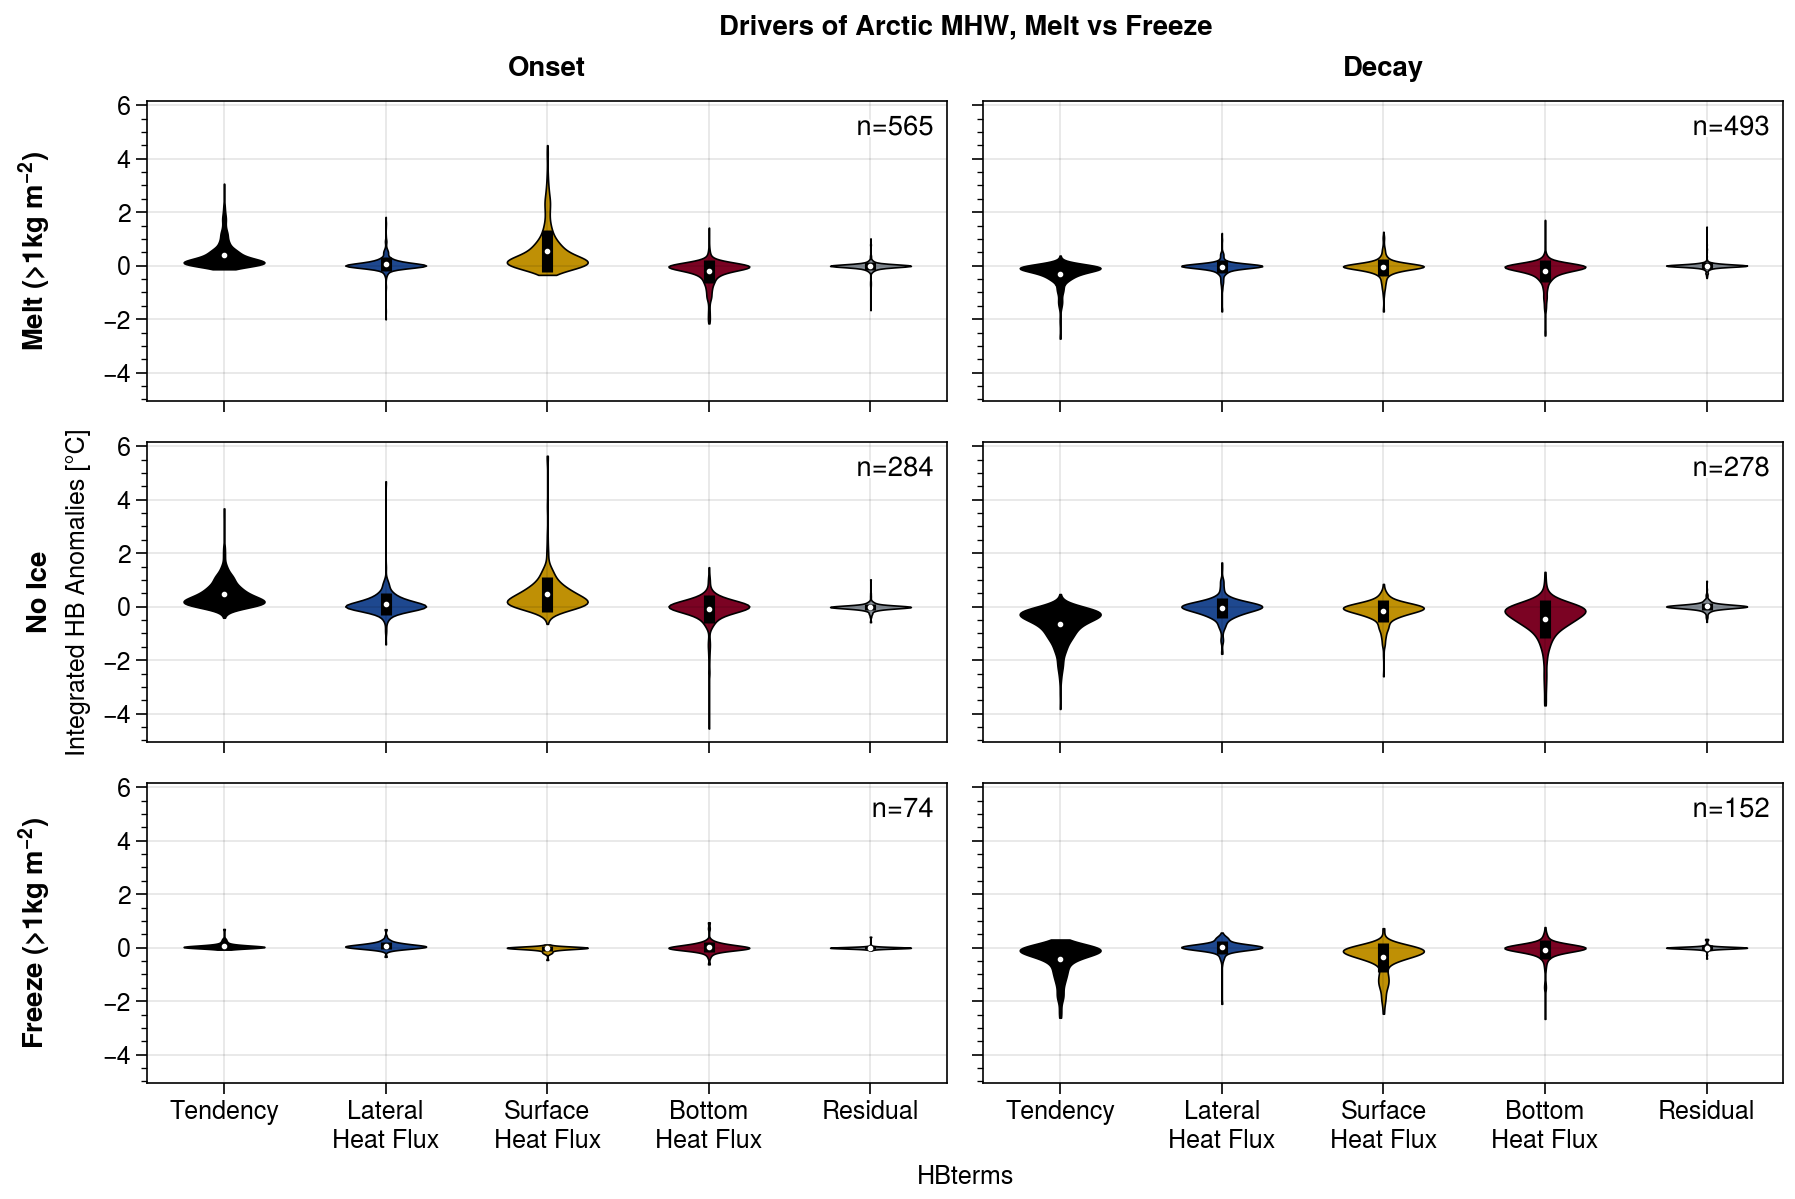

In [14]:
# Start plotting violin plots to have an overall statistical view of the primary process for each phase
cycle = pplt.Cycle(c=CycleHB)
fig, ax = pplt.subplots(nrows=3,ncols=2,axwidth=4,axheight=1.5, sharey=4)
# Ice melt
# Onset
ax[0].violin(da_attr_onset_Melt.transpose(),means=True,cycle=cycle)
ax[0].format(title='n='+str(da_attr_onset_Melt.shape[1]),titleloc='ur') # Add number of MHWs in that phase as annotation
# Decay
ax[1].violin(da_attr_decay_Melt.transpose(),means=True,cycle=cycle)
ax[1].format(title='n='+str(da_attr_decay_Melt.shape[1]),titleloc='ur')
# No Ice:
# Onset
ax[2].violin(da_attr_onset_NoFM.transpose(),means=True,cycle=cycle)
ax[2].format(title='n='+str(da_attr_onset_NoFM.shape[1]),titleloc='ur')
#Decay
ax[3].violin(da_attr_decay_NoFM.transpose(),means=True,cycle=cycle)
ax[3].format(title='n='+str(da_attr_decay_NoFM.shape[1]),titleloc='ur')
# Freezing
# Onset
ax[4].violin(da_attr_onset_Frze.transpose(),means=True,cycle=cycle)
ax[4].format(title='n='+str(da_attr_onset_Frze.shape[1]),titleloc='ur')
#Decay
ax[5].violin(da_attr_decay_Frze.transpose(),means=True,cycle=cycle,)
ax[5].format(title='n='+str(da_attr_decay_Frze.shape[1]),titleloc='ur')
# Formatting
ax.format(ylabel='Integrated HB Anomalies [°C]',xticklabels=HBlabel2plot, 
          leftlabels=['Melt (>1kg m$^{-2}$)','No Ice','Freeze (>1kg m$^{-2}$)'], toplabels=['Onset','Decay'])
fig.suptitle('Drivers of Arctic MHW, Melt vs Freeze')
fig.format(facecolor='w')

Text(0.5, 0.98, 'Sea Ice and Marine Heatwaves')

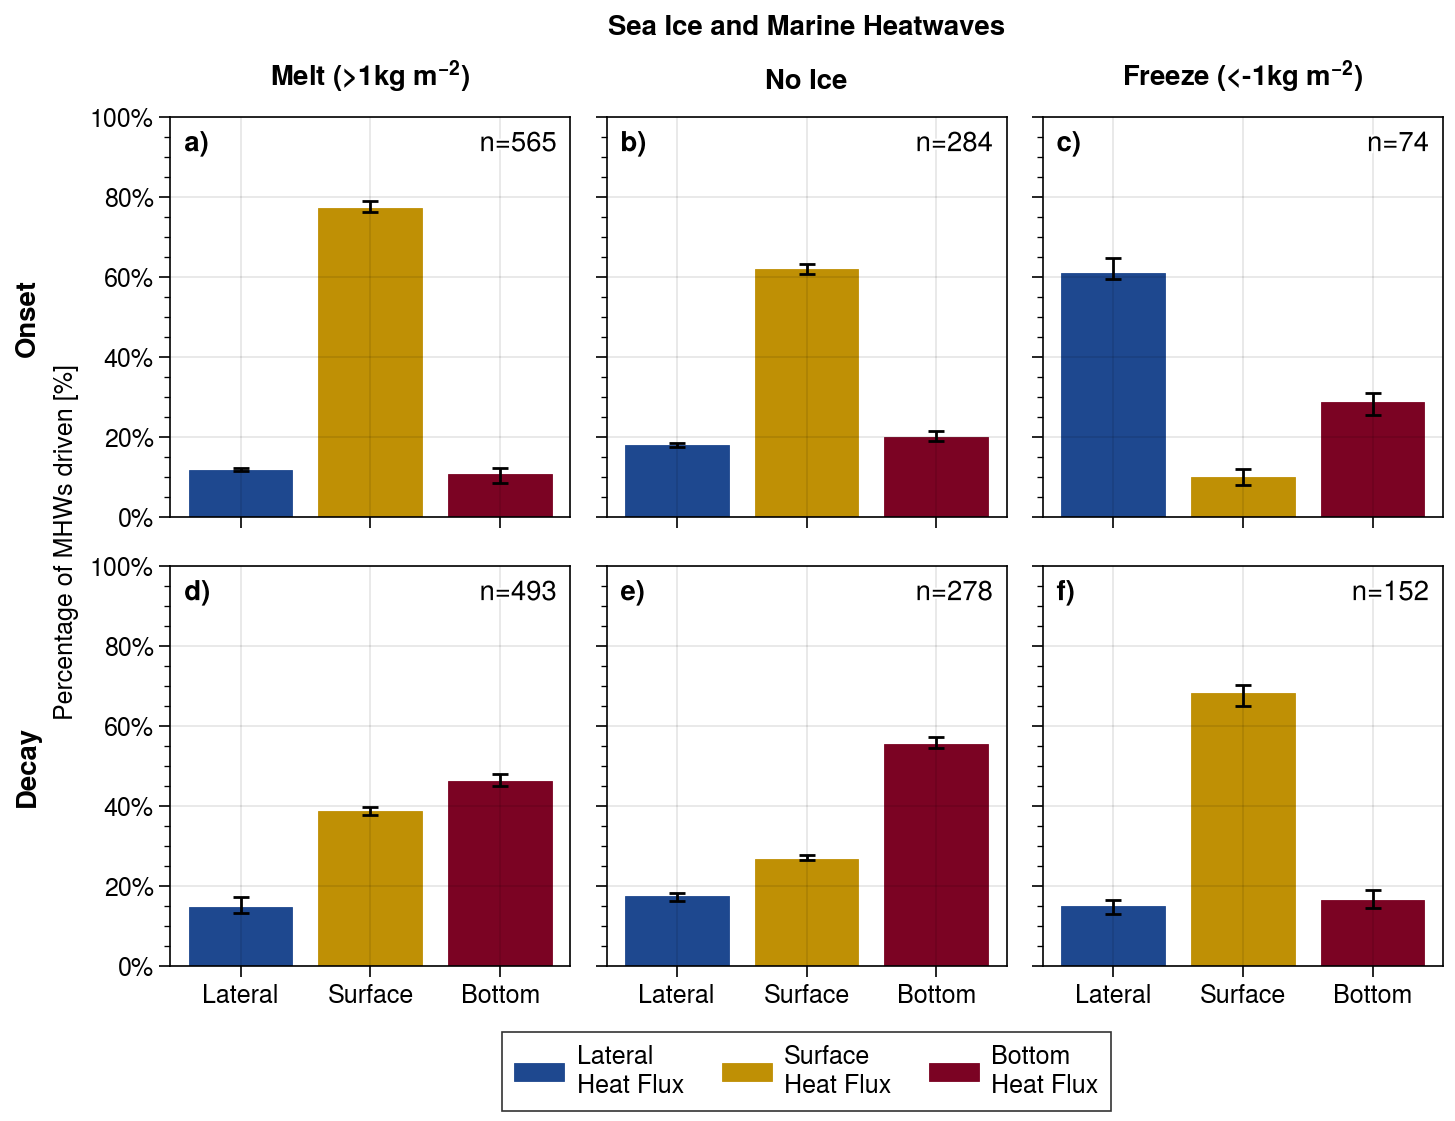

In [13]:
# Now can plot it all in bar plots. Similar, but better for publication
fig, axs = pplt.subplots(ncols=3,nrows=2,refwidth=2,)
# Onset
# Ice melt
h_bar = axs[0].bar(df_Onset_melt_rank1/df_Onset_melt_rank1.sum(axis=1)[0]*100,mean=True,barpctile=100,color=CycleHB[1:4],)
axs[0].format(title='n='+str(df_Onset_melt_rank1.sum(axis=1)[0].astype('int')),titleloc='ur')
# No Ice:
axs[1].bar(df_Onset_nofm_rank1/df_Onset_nofm_rank1.sum(axis=1)[0]*100,mean=True,barpctile=100,color=CycleHB[1:4],)
axs[1].format(title='n='+str(df_Onset_nofm_rank1.sum(axis=1)[0].astype('int')),titleloc='ur')
# Freezing
axs[2].bar(df_Onset_frze_rank1/df_Onset_frze_rank1.sum(axis=1)[0]*100,mean=True,barpctile=100,color=CycleHB[1:4],)
axs[2].format(title='n='+str(df_Onset_frze_rank1.sum(axis=1)[0].astype('int')),titleloc='ur')
# Decay
# Ice melt
axs[3].bar(df_Decay_melt_rank1/df_Decay_melt_rank1.sum(axis=1)[0]*100,mean=True,barpctile=100,color=CycleHB[1:4])
axs[3].format(title='n='+str(df_Decay_melt_rank1.sum(axis=1)[0].astype('int')),titleloc='ur')
# No Ice:
axs[4].bar(df_Decay_nofm_rank1/df_Decay_nofm_rank1.sum(axis=1)[0]*100,mean=True,barpctile=100,color=CycleHB[1:4])
axs[4].format(title='n='+str(df_Decay_nofm_rank1.sum(axis=1)[0].astype('int')),titleloc='ur')
# Freezing
axs[5].bar(df_Decay_frze_rank1/df_Decay_frze_rank1.sum(axis=1)[0]*100,mean=True,barpctile=100,color=CycleHB[1:4])
axs[5].format(title='n='+str(df_Decay_frze_rank1.sum(axis=1)[0].astype('int')),titleloc='ur')
# Formatting
axs[3:6].format(xticklabels=['Lateral','Surface','Bottom'])
axs.format(leftlabels=['Onset','Decay'],toplabels=['Melt (>1kg m$^{-2}$)','No Ice','Freeze (<-1kg m$^{-2}$)'],
           abc='a)', abcloc='ul',
           yformatter='percent',ylim=[0,100],ylabel='Percentage of MHWs driven [%]',
          )
fig.legend(h_bar[1].get_children(),labels=HBlabel2plot[1:4],loc='b',)
fig.suptitle("Sea Ice and Marine Heatwaves")
# fig.save(Path2figs.joinpath("BarPlot_IceMHWimpact_Drvr1_wResiduals.png"),dpi=400)

The following version, a bit older, works well as well and is better plotted as pie chart with the residuals.

In [16]:
# Preprocess the rankings for Melt, Freeze and no ice
df_fmflx_onset = ds_mhw_fmflx['FMFlux'].sel(trend='Onset',drop=True).to_dataframe(dim_order=('tiles','mhw')).dropna()
df_fmflx_decay = ds_mhw_fmflx['FMFlux'].sel(trend='Decay',drop=True).to_dataframe(dim_order=('tiles','mhw')).dropna()
df_NoResCorr_Onset_rk1 =  ds_NoResCorr_Onset_ranks.where(ds_NoResCorr_Onset_ranks==1)
df_NoResCorr_Onset_Melt = df_NoResCorr_Onset_rk1.where(df_fmflx_onset['FMFlux']<-1).sum()
df_NoResCorr_Onset_NoFM = df_NoResCorr_Onset_rk1.where((df_fmflx_onset['FMFlux']>=-1) & (df_fmflx_onset['FMFlux']<=1)).sum()
df_NoResCorr_Onset_Frze = df_NoResCorr_Onset_rk1.where(df_fmflx_onset['FMFlux']>1).sum()
df_NoResCorr_Decay_rk1 =  ds_NoResCorr_Decay_ranks.where(ds_NoResCorr_Decay_ranks==1)
df_NoResCorr_Decay_Melt = df_NoResCorr_Decay_rk1.where(df_fmflx_decay['FMFlux']<-1).sum()
df_NoResCorr_Decay_NoFM = df_NoResCorr_Decay_rk1.where((df_fmflx_decay['FMFlux']>=-1) & (df_fmflx_decay['FMFlux']<=1)).sum()
df_NoResCorr_Decay_Frze = df_NoResCorr_Decay_rk1.where(df_fmflx_decay['FMFlux']>1).sum()

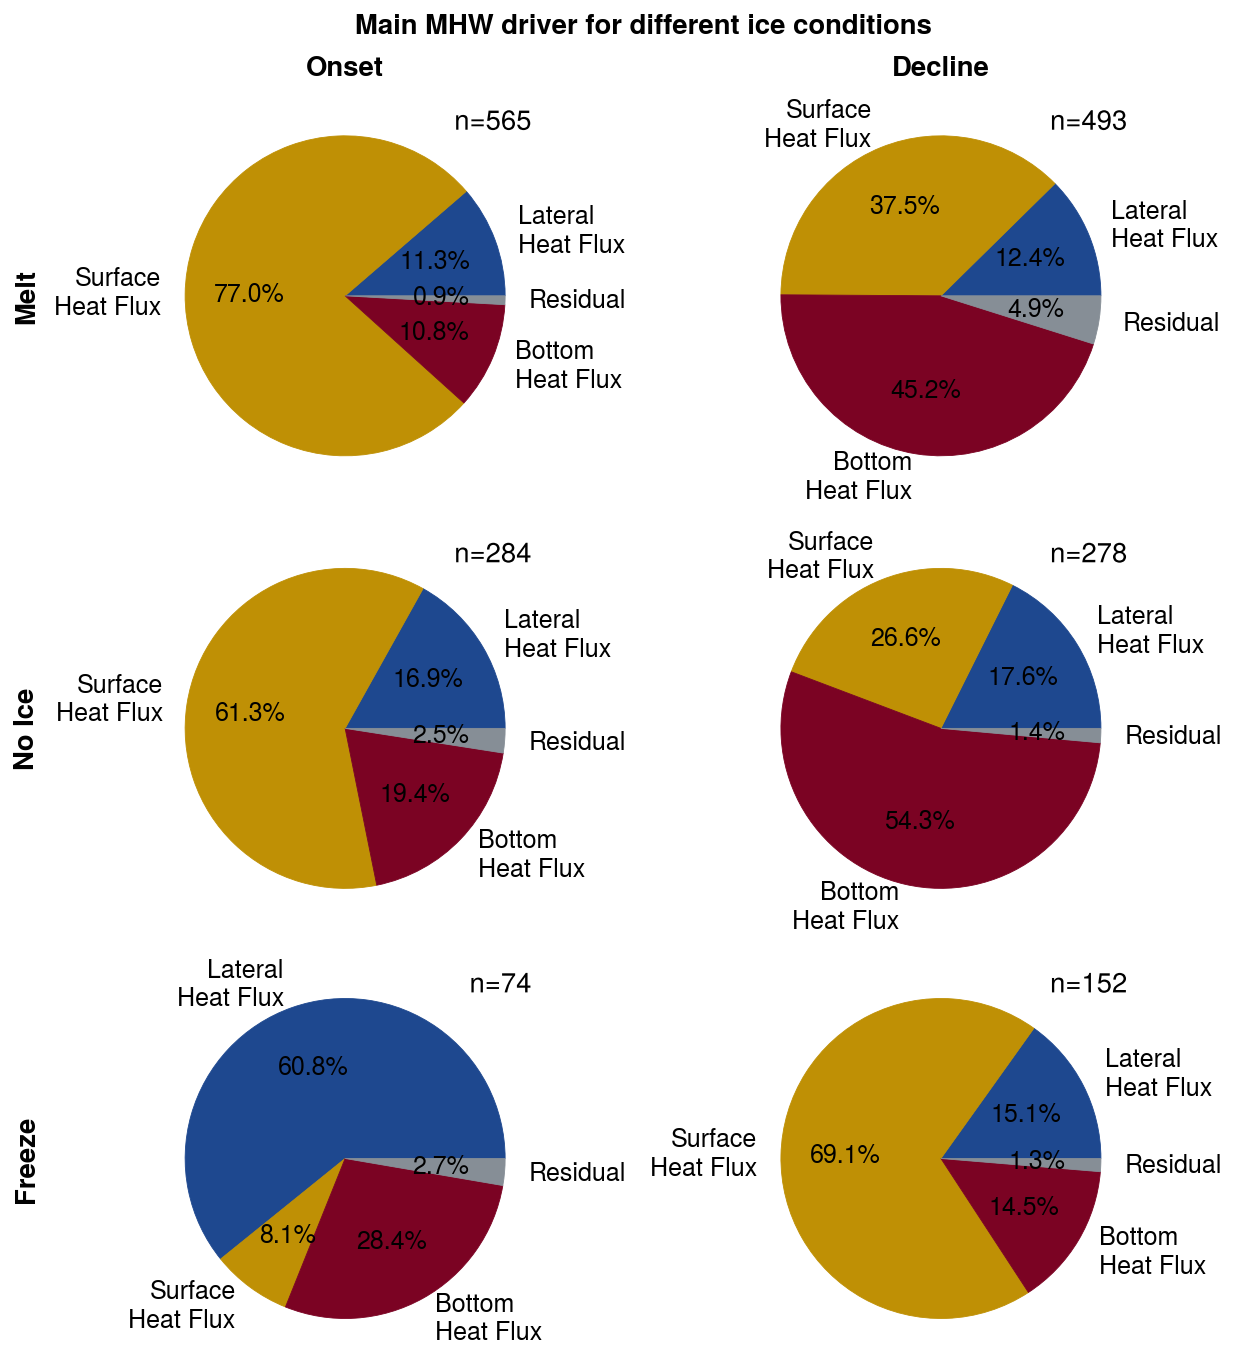

In [17]:
fig, axs = pplt.subplots(nrows=3, ncols=2,axwidth=2)
axs[0].pie(df_NoResCorr_Onset_Melt,startangle=0,
           cycle=CycleHB[1:],labels=HBlabel2plot[1:5], autopct='%1.1f%%')
axs[0].format(title='n='+str(df_NoResCorr_Onset_Melt.sum().astype('int')),titleloc='ur')
axs[1].pie(df_NoResCorr_Decay_Melt,startangle=0,
           cycle=CycleHB[1:],labels=HBlabel2plot[1:5], autopct='%1.1f%%')
axs[1].format(title='n='+str(df_NoResCorr_Decay_Melt.sum().astype('int')),titleloc='ur')
axs[2].pie(df_NoResCorr_Onset_NoFM,startangle=0,
           cycle=CycleHB[1:],labels=HBlabel2plot[1:5], autopct='%1.1f%%')
axs[2].format(title='n='+str(df_NoResCorr_Onset_NoFM.sum().astype('int')),titleloc='ur')
axs[3].pie(df_NoResCorr_Decay_NoFM,startangle=0,
           cycle=CycleHB[1:],labels=HBlabel2plot[1:5], autopct='%1.1f%%')
axs[3].format(title='n='+str(df_NoResCorr_Decay_NoFM.sum().astype('int')),titleloc='ur')
axs[4].pie(df_NoResCorr_Onset_Frze,startangle=0,
           cycle=CycleHB[1:],labels=HBlabel2plot[1:5], autopct='%1.1f%%')
axs[4].format(title='n='+str(df_NoResCorr_Onset_Frze.sum().astype('int')),titleloc='ur')
axs[5].pie(df_NoResCorr_Decay_Frze,startangle=0,
           cycle=CycleHB[1:],labels=HBlabel2plot[1:5], autopct='%1.1f%%')
axs[5].format(title='n='+str(df_NoResCorr_Decay_Frze.sum().astype('int')),titleloc='ur')

axs.format(toplabels=['Onset','Decline'],leftlabels=['Melt','No Ice','Freeze'])
fig.suptitle("Main MHW driver for different ice conditions")
fig.format(facecolor='white')

### Investigate Temperature vertical profile when freezing
The fact that we still have MHW onsets during freezing phase can seem surprising and counter-intuitive. Two potential hypothesis:
* the spatial area covered by a tile could allow for ice freezing on one side of the tile while a MHW is occurring on another side
* The temperature is not homogeneous in the mixed layer because of the salinity stratification and freezing conditions at the surface could be overlaying warm water intrusions below, either from lateral advection, or from vertical entrainment.

Plotting the temperature profile in the ML for some of those freezing onsets could help determine if this second hypothesis is indeed possible.

In [342]:
# First things first, need to pinpoint which tile and MHW to investigate. Select freezing MHWs
df_dTdtWRes_Onset_rk1.where(df_fmflx_onset['FMFlux']>1).dropna(axis=0,how='all')[40:60]

TotAdv_top  Qsr_net_top  Vert_Flux
tiles mhw                                    
613   1           1.0          NaN        NaN
685   10          NaN          1.0        NaN
686   9           1.0          NaN        NaN
      10          NaN          NaN        1.0
714   11          NaN          NaN        1.0
739   0           NaN          NaN        1.0
740   1           NaN          NaN        1.0
      2           NaN          NaN        1.0
      3           NaN          NaN        1.0
741   6           1.0          NaN        NaN
745   3           1.0          NaN        NaN
768   1           1.0          NaN        NaN
      2           NaN          NaN        1.0
      3           1.0          NaN        NaN
      4           1.0          NaN        NaN
      5           1.0          NaN        NaN
      10          1.0          NaN        NaN
769   0           1.0          NaN        NaN
      1           1.0          NaN        NaN
      2           1.0          NaN        NaN

In [18]:
# Now need to load the data for this, in particular Mixed Layer temperature for the tile.
# Define a few new paths.
Path2Temptiles = Path(PathHome+"/Projects/SiberianHW/data/interim/tiles")
Path_grid = Path(PathHome+"/Data/3Oceans/")
# Load the climato and thresh for MLT for all tiles, and the MLD
ds_clims = xr.open_dataset(Path2proc.joinpath("ClimThreshSmooth_MLT_Tiled3O.nc"))
ds_MLD =xr.open_dataset(Path2proc.joinpath("MLD_tiles_3Oceans.nc"))
# Load the CREG grid to be able to do a weighted average of MLT later on.
aux_files = Path_grid.joinpath("CREG025_grid.nc")
ds_grid = xr.open_dataset(aux_files).squeeze().rename({'NAV_LAT':'latitude', 'NAV_LON':'longitude'})
# A dtiny bit of renaming of coordinates
ds_grid = ds_grid.assign_coords({'z':('Z',ds_grid.DEPTHT.data)}).swap_dims({'Z':'z'}).drop(['Z']).drop_dims(['DEPTHT'])
ds_tiles_fullgrid = xr.open_dataset(Path2proc.joinpath("Tiles_3Oceans_20x20_4HB.nc"))

/home/brichaud/.conda/envs/SibHW_env/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


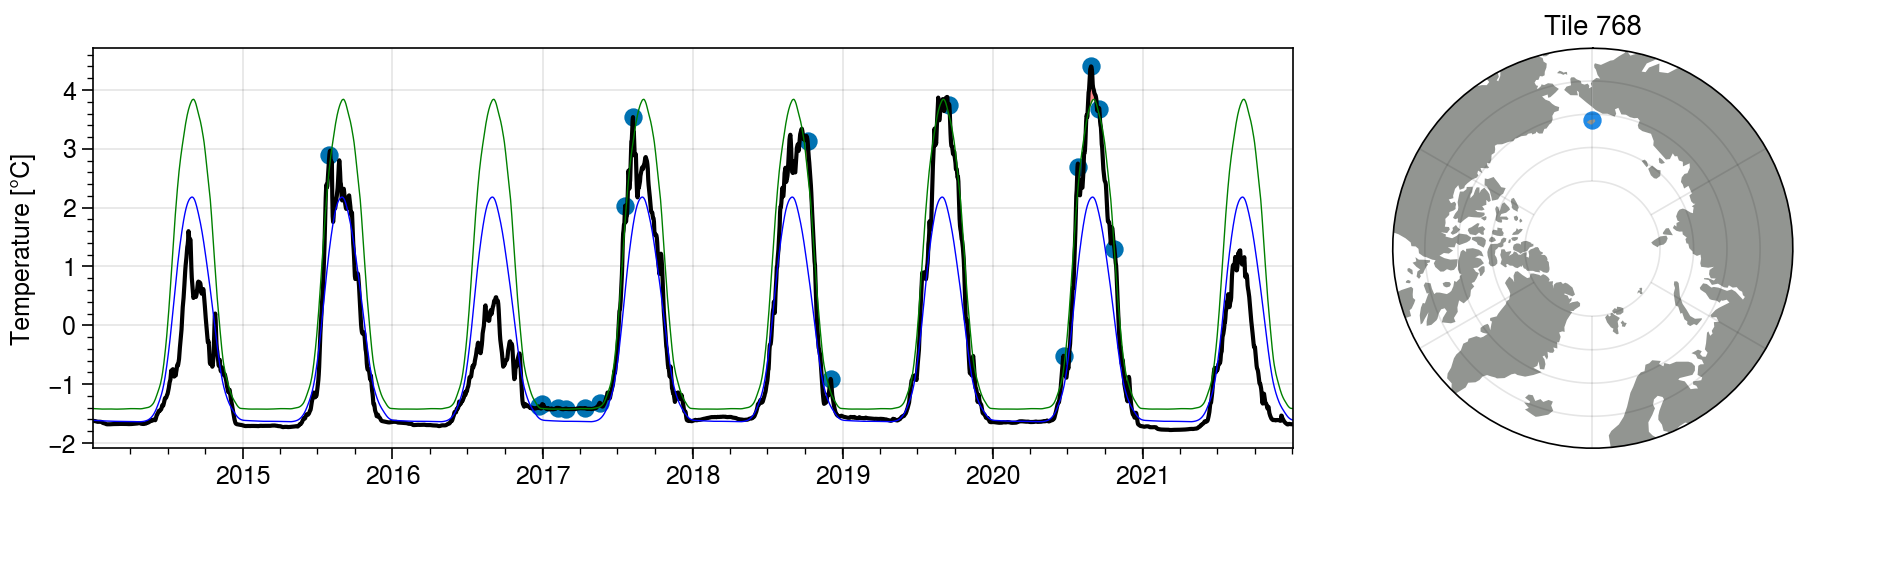

In [19]:
# Select the MHW and tile of interest
# tt, mhw = 740, 3
tt, mhw = 768, 4
# tt, mhw = 561, 14
# tt, mhw = 686, 9
# Extract MHW metrics and properties
MHW2plot = ds_mhws_filt.sel(tiles=tt).dropna(dim='mhw')
# Plot the results
fig = pplt.figure(axwidth=6,axheight=2,sharey=0, sharex=3)
axs = fig.subplots([[1,1,0]])
# First panel: MLT, clim, thresh and MHW
axs[0].plot(ds_MLT.toce.sel(tiles=tt),c='k',label='MLT')
axs[0].plot(ds_MLT.time,ds_clims.seas.sel(tiles=tt),c='b',lw=0.5, label='Clima')
axs[0].plot(ds_MLT.time,ds_clims.thresh.sel(tiles=tt),c='g',lw=0.5, label='Thresh')
axs[0].area(ds_MLT.time, ds_clims.thresh.sel(tiles=tt), ds_MLT.sel(tiles=tt).toce, 
            negpos=True, negcolor='None', poscolor='red4')
h2=axs[0].scatter(ds_MLT.time.isel(time=MHW2plot.index_peak.astype('int')),
               MHW2plot.intensity_max_abs,label='Filtered (mean>0.1)')
axs[0].format(ylabel='Temperature [°C]',
              # xlim=[np.datetime64('2018-01-01'),np.datetime64('2018-09-01')],
              # ylim=[-2,-1.0]
             )
axs.format(xrotation=0)

# Map of location of tile
proj=pplt.Proj('nplaea')
ax_end = fig.subplot(1,3,(3), projection=proj,)
ax_end.scatter(ds_mhws_filt.sel(tiles=tt).longitude.values, 
               ds_mhws_filt.sel(tiles=tt).latitude.values, 
               color='blue6')
ax_end.format(boundinglat=60, land=True, landcolor='grey', title='Tile '+str(tt))

In [20]:
# Calculate temperature for the tile only:
# Load the 3D temperature for the tile
ds_Temp_tile = xr.open_dataset(Path2Temptiles.joinpath('CREG025E_era5_1d_toce_tile'+str(tt)+'.nc'))
# Extract the volume of each grid cell in the tile 
ds_gridweight = ds_grid.VOL.where(ds_tiles_fullgrid==tt,drop=True)
# Weight the temperature with that volume and do a 2D (horizontal) average
ds_Temp_WC = ds_Temp_tile.weighted(ds_gridweight.TileNumber.fillna(0)).mean(dim=['x','y'])

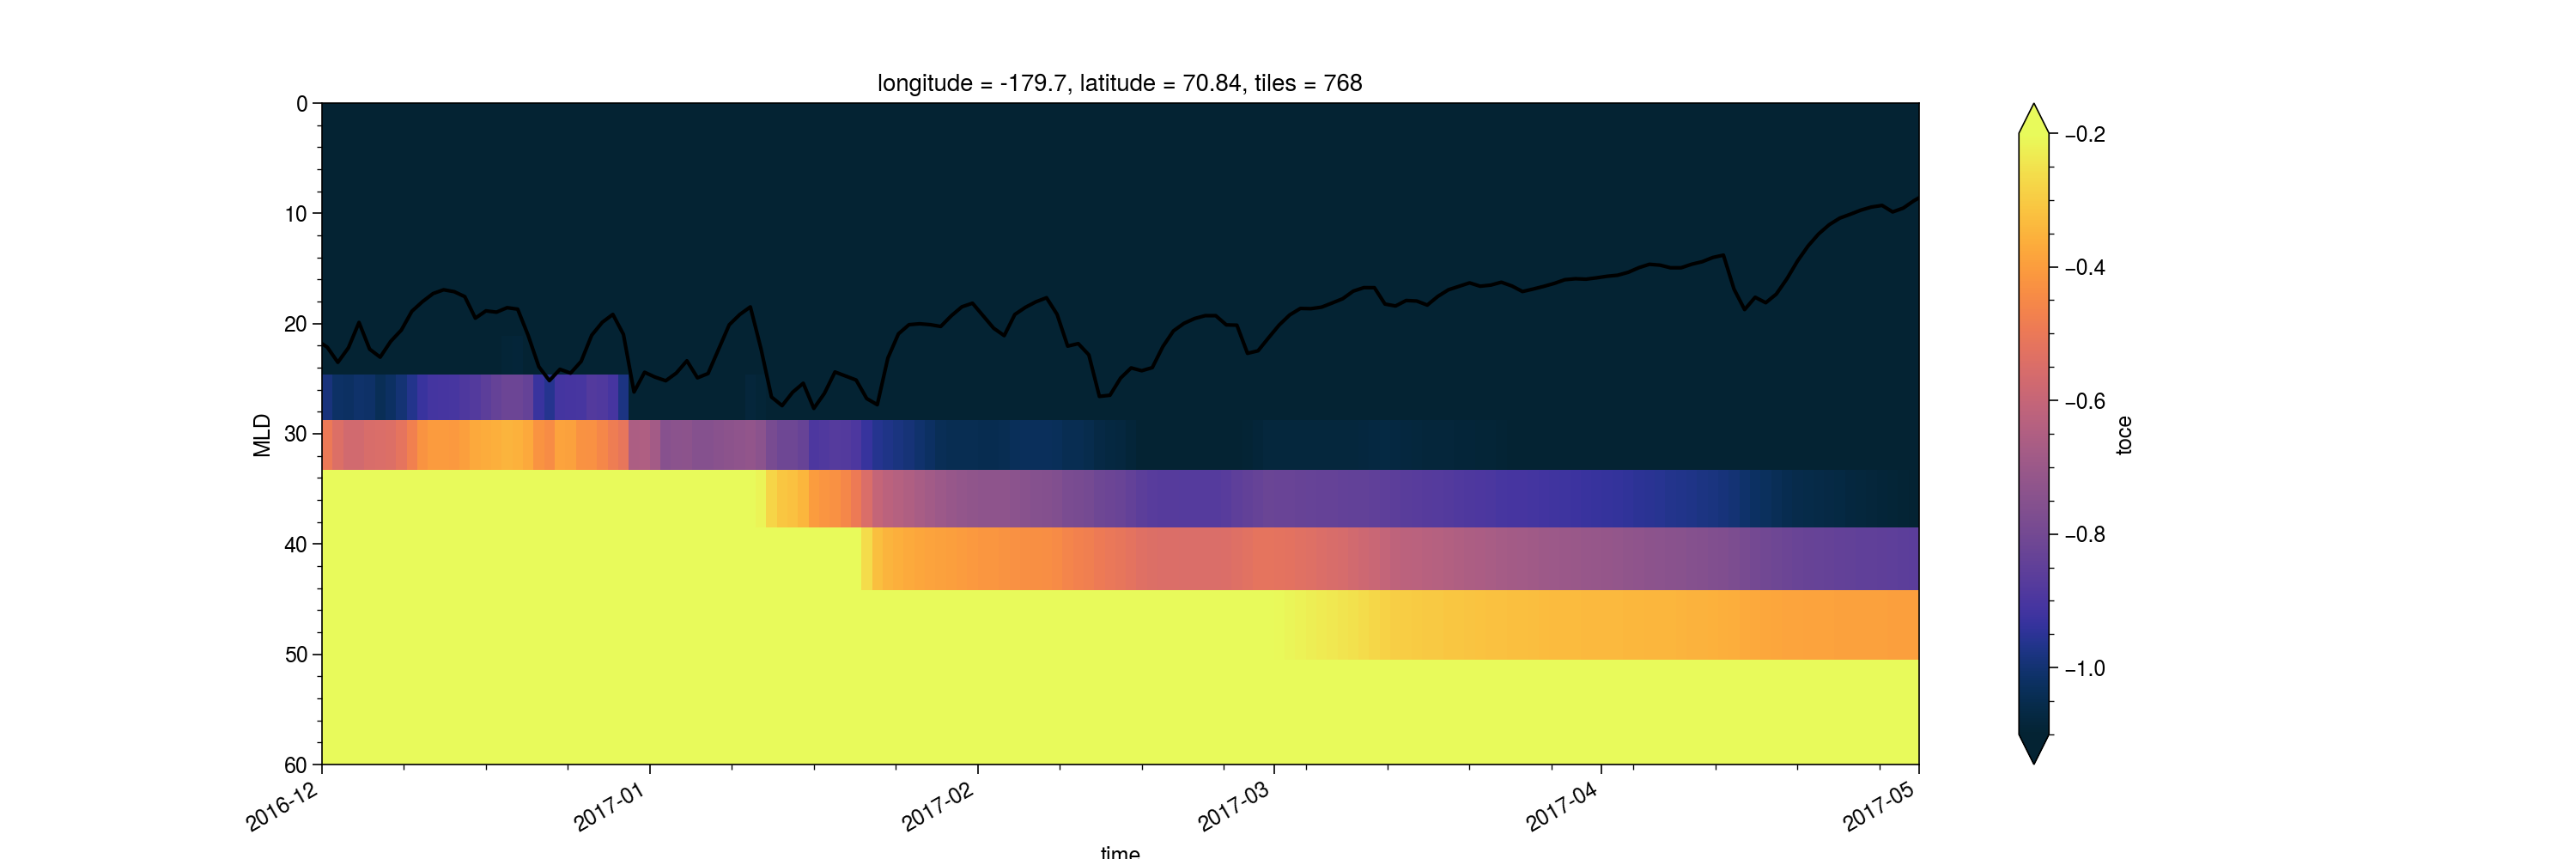

In [23]:
# Quickly plot a Hovmoeller plot of this MLT and the MLD (you gotta love xarray for that...)
ds_Temp_WC.toce.transpose().plot(ylim=[60,0], 
                                 xlim=[np.datetime64('2016-12-01'),np.datetime64('2017-05-01')],
                                 # xlim=[np.datetime64('2020-11-01'),np.datetime64('2021-05-01')],
                                 # xlim=[np.datetime64('2014-12-01'),np.datetime64('2015-06-01')],
                                 aspect=3,size=5,cmap='thermal',vmin=-1.1,vmax=-0.2)
ds_MLD.sel(tiles=tt).MLD.plot(c='k')

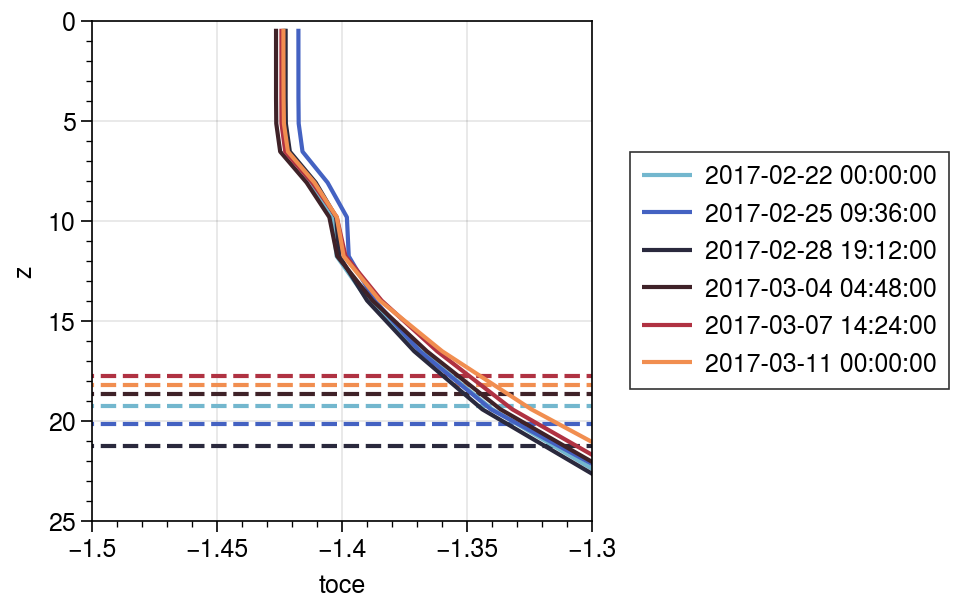

In [25]:
# Extract start date and end date of the specific MHW
start = ds_mhws_filt.sel(tiles=tt,mhw=mhw)['date_start'].values
end = ds_mhws_filt.sel(tiles=tt,mhw=mhw)['date_end'].values
L_mhw = int(ds_mhws_filt.duration.sel(tiles=tt,mhw=mhw).values)
# Then plot profiles.
fig, ax = pplt.subplots()
cycle=pplt.Cycle('ICeFire',L_mhw//3,left=0.1,right=0.9)
# Loop over dates, with some temporal increment
for i, dd in enumerate(pd.date_range(start, end,L_mhw//3)):
    # Plot the MLT profile
    ax.plot(x='toce',y='z',data=ds_Temp_WC.sel(time=dd,method='nearest').transpose(),
            label=dd,cycle=cycle)
    # Add a horizontal line for the MLD
    ax.hlines(ds_MLD.sel(tiles=tt).MLD.sel(time=dd,method='nearest').data,-2,0,color=pplt.get_colors(cycle)[i],ls='--')
# Some formatting.
ax.format(ylim=[25,0],xlim=[-1.5,-1.3])
ax.legend(loc='r',ncols=1)